### Installation

In [ ]:
try:
    import google.colab
    COLAB = True
    ! pip install gymnasium==0.29.1 vizdoom==1.2.4 wandb==0.19.1
except:
    COLAB = False

NEED_DRIVE = True
HAS_DRIVE = False

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.1.0
    Uninstalling gymnasium-1.1.0:
      Successfully uninstalled gymnasium-1.1.0
  Attempting uninstall: wandb
    Found existing installation: wandb 0.19.8
    Uninstalling wandb-0.19.8:
      Successfully uninstalled wandb-0.19.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


In [ ]:
if NEED_DRIVE and COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    HAS_DRIVE = True

Mounted at /content/drive


In [ ]:
import json
import math
import random
import sys
import os
import time
from collections import deque
from typing import Dict, Type, Any, Tuple, NamedTuple, Optional, Union, Generator, List

import gymnasium as gym
import gymnasium.spaces as spaces
from gymnasium.vector import AsyncVectorEnv, SyncVectorEnv
from gymnasium.wrappers import ResizeObservation, GrayScaleObservation, RecordEpisodeStatistics, TransformReward, \
    FrameStack
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions import Categorical
import vizdoom
from vizdoom import gymnasium_wrapper

try:
    import wandb
    WANDB_IS_AVAILABLE = True
except ImportError:
    WANDB_IS_AVAILABLE = False

os.environ["WANDB_API_KEY"] = "your wandb-api key"

### Environment: Vizdoom
Среда для экспериментов: **Vizdoom**. Задача: **VizdoomCorridor-v0**.

Карта представляет собой коридор со стреляющими противниками по обеим сторонам. Зелёная броня размещена на противоположном конце коридора. Цель агента — добраться до предмета. Награда пропорциональна (отрицательна или положительна) изменению расстояния между игроком и жилетом.
- Вознаграждение: +dX за приближение к броне, -dX за отдаление от брони, -100 за смерть.
- Агенту доступны 7 действий: движение вперед/назад/влево/вправо, поворот влево/вправо, стрельба.
- Ограничение по времени: 2100 шагов

Для ускорения обучения агента рассматриваем самый простой уровень сложности `doom_skill = 1`.

/usr/local/lib/python3.11/dist-packages/vizdoom/gymnasium_wrapper/base_gymnasium_env.py:84: UserWarning: Detected screen format CRCGCB. Only RGB24 and GRAY8 are supported in the Gymnasium wrapper. Forcing RGB24.
  warnings.warn(


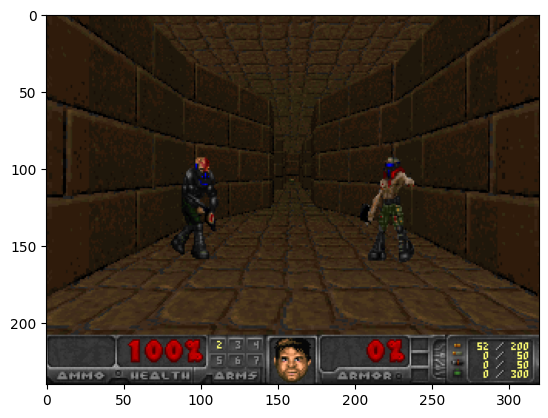

{'scenario_file': '/content/deadly_corridor_doom-skill-1.cfg'}


In [ ]:
def create_vizdoom_config(verbose=False):
    # Создаёт файл сценария VizdoomCorridor с уровнем сложности doom_skill = 1

    deadly_corridor_doom_skill_1 = """
    # Lines starting with # are treated as comments (or with whitespaces+#).
    # It doesn't matter if you use capital letters or not.
    # It doesn't matter if you use underscore or camel notation for keys, e.g. episode_timeout is the same as episodeTimeout.
    """
    deadly_corridor_doom_skill_1 += f"\ndoom_scenario_path = {os.path.relpath(os.path.dirname(vizdoom.__file__))}/scenarios/deadly_corridor.wad\n"
    deadly_corridor_doom_skill_1 += """
    # Skill 5 is recommended for the scenario to be a challenge.
    doom_skill = 1

    # Rewards
    death_penalty = 100
    #living_reward = 0

    # Rendering options
    screen_resolution = RES_320X240
    screen_format = CRCGCB
    render_hud = true
    render_crosshair = false
    render_weapon = true
    render_decals = false
    render_particles = false
    window_visible = true

    episode_timeout = 2100

    # Available buttons
    available_buttons =
      {
        MOVE_LEFT
        MOVE_RIGHT
        ATTACK
        MOVE_FORWARD
        MOVE_BACKWARD
        TURN_LEFT
        TURN_RIGHT
      }

    # Game variables that will be in the state
    available_game_variables = { HEALTH }

    mode = PLAYER
    """

    config_file_name = f'deadly_corridor_doom-skill-1.cfg'
    with open(config_file_name, 'w') as file_obj:
        print(deadly_corridor_doom_skill_1, file=file_obj)

    if verbose:
        print(deadly_corridor_doom_skill_1)

    return os.path.realpath(config_file_name)


def source_env_info():
    config_file_path = create_vizdoom_config()
    env = gym.make('VizdoomCorridor-v0', **{'scenario_file': config_file_path})
    obs, _ = env.reset()
    plt.imshow(obs['screen'])
    plt.show()
    print(env.env.env.spec.kwargs)

source_env_info()

### Wrappers

In [ ]:
class ImageExtractorWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = env.observation_space['screen']

    def observation(self, observation: Dict) -> np.ndarray:
        return observation['screen']


def make_env():
    config_file_path = create_vizdoom_config()
    env = gym.make('VizdoomCorridor-v0', **{'scenario_file': config_file_path})
    env = ImageExtractorWrapper(env)
    env = GrayScaleObservation(env)
    env = ResizeObservation(env, shape=84)
    env = FrameStack(env, num_stack=3)
    env = RecordEpisodeStatistics(env)
    env = TransformReward(env, f=lambda reward: reward / 100.)

    return env


def wrapped_env_info():
    config_file_path = create_vizdoom_config()
    env = make_env()
    env.reset()
    terminated = False
    while not terminated:
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    for ax, frame in zip(axes, obs):
        ax.imshow(frame, cmap='gray')

    print('Наблюдение - стек из 3х последовательных изображений 84х84 в оттенках серого, shape:', obs.shape)
    plt.show()
    print('info на последнем шаге содержит статистику эпизода: r - суммарное вознаграждение, l - длина эпизода, t - продолжительность эпизода в секундах\n', info)

DEMO_WRAPPED_ENV = False
if DEMO_WRAPPED_ENV:
    wrapped_env_info()

### Misc

In [ ]:
def set_seed_everywhere(seed: int, using_cuda: bool = False) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if using_cuda:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Методы на основе REINFORCE

Обозначения:
- $s$ - состояние, $r$ - вознаграждение, $a$ - действие
- Условное распределение действий $\pi(a | s)$ - стратегия агента
- $\tau$ - траектория: $(s_0, r_0, a_0), \dots, (s_T, r_T, a_T)$
- Отдача $G(\tau) = \sum_{t = 0} ^ T r_t \gamma ^ t$
- $G_t = r_t + r_{t + 1} \gamma + \dots + r_{T} \gamma ^ {T - t}$
- Функция полезности состояний: $V(s_{t}) = \mathbb{E}[G_t]$
- Функция полезности действий: $Q(s_t, a_t) = \mathbb{E}[r_t + \gamma V(s_{t + 1}) | a_t]$

REINFORCE:

$$J(\theta)= \mathbb{E}[G(\tau)],$$

$$\theta \leftarrow \theta +\alpha \nabla_{\theta} J(\theta),$$

Варианты скор-функции:
$$\nabla_\theta J(\theta) = \mathbb{E}_\pi [Q^\pi(s, a) \nabla_\theta \ln \pi_\theta(a \vert s)]$$
$$\nabla_\theta J(\theta) = \mathbb{E}_\pi [G_t \nabla_\theta \ln \pi_\theta(a_t \vert s_t)]$$
$$\nabla_\theta J(\theta) = \mathbb{E}_\pi [A_t \nabla_\theta \ln \pi_\theta(a_t \vert s_t)]$$

### Недостатки
#### Нестабильное обучение
- Большой шаг обновления параметров стратегии $\rightarrow$ "плохая" стратегия $\rightarrow$ rollout собирается "плохой" стратегией $\rightarrow$ "плохие" данные $\rightarrow$ обновление стратегии на "плохих" данных $\rightarrow$ ухудшение стратегии
- Малый размер шага обучения $\rightarrow$ медленное обучение (низкий КПД использования данных)
- **Малое изменение параметров стратегии не гарантирует, что изменение распределения будет небольшим!**

#### Эффективность использования данных в on-policy режиме (AAC, REINFORCE, ...)
- Стратегия обновляется по траекториям, которые были получены этой же стратегией, т.е. данные нельзя переиспользовать
- Обучение нейронной сети требует большого количества итераций обновления параметров, т.е. большого количества эпизодов взаимодействия со средой.

#### Сложности с эффективным применением N-шаговой отдачи с большим N
- N-шаговая отдача с $N \approx \frac{1}{1 - \gamma}$ может снизить смещение в оценке преимущества $A(s, a)$, при этом дисперсию оценки можно контролировать с помощью параметра $\lambda$ в GAE (General Advantage Estimation)
- Для эффективного обучения на "длинных" кусках траекторий необходимо разбиение данных на батчи, что противоречит on-policy режиму

#### Результаты A2C в Atari Pong при увеличении N и количества эпох обучения на собранных данных
<img src="https://ale.farama.org/_images/pong.gif">

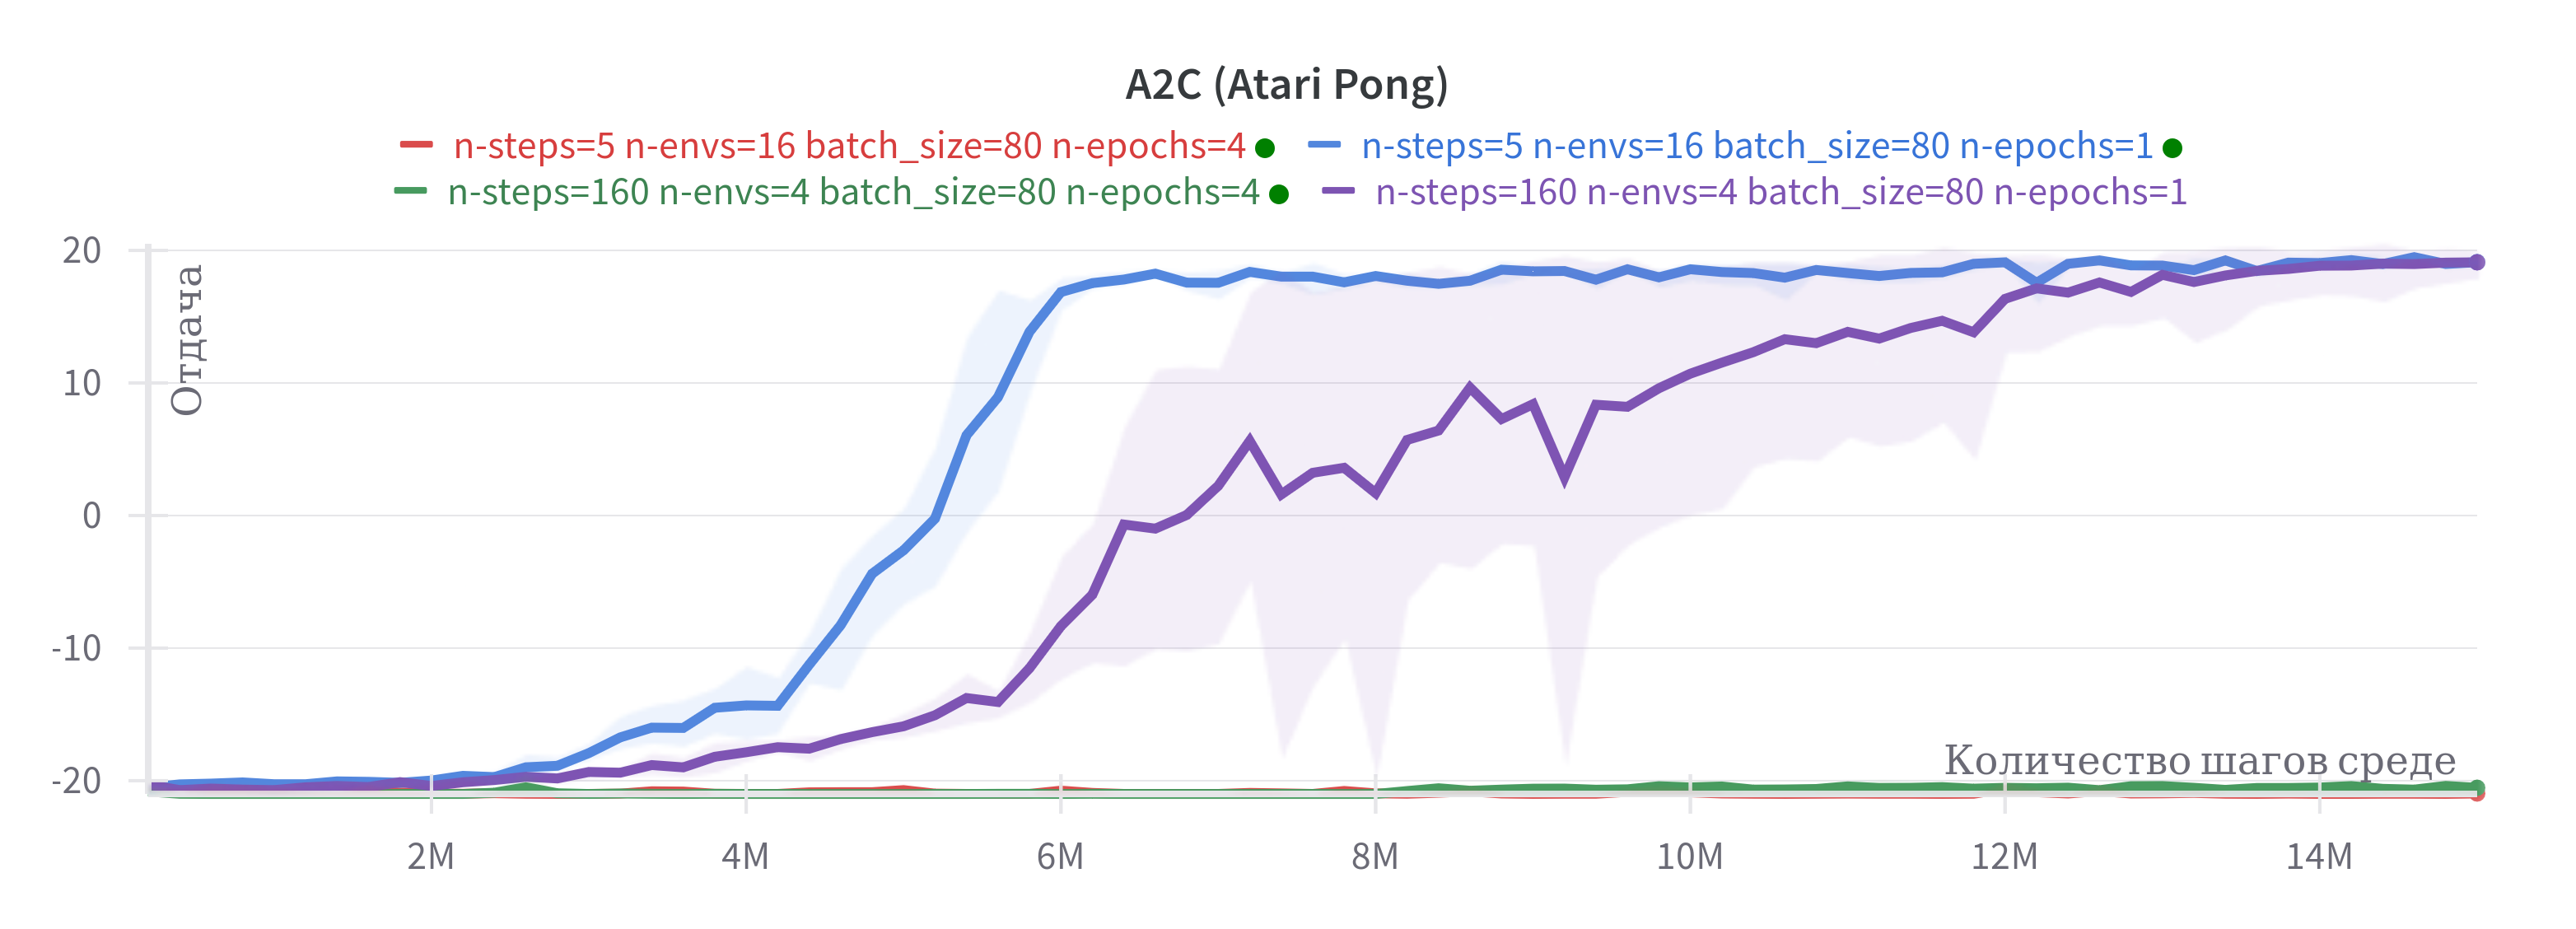

# 1 Суррогатный функционал оптимизации стратегии
$$J(\theta) = \mathbb{E}_{(s, a) \sim \pi_{\theta} ^ {old}} \left[ \dfrac{\pi_{\theta}(a|s)}{\pi_{\theta} ^ {old}(a | s)} A(s, a) \right]$$
$$\theta \leftarrow \theta +\alpha \nabla_{\theta} J(\theta),$$
Реализуем батч-версию алгоритма актор-критик с функцией преимущества и суррогатным функционалом обучения стратегии.

#### Policy
Основные компоненты ReinforcePolicy:
- `features_extractor` - свёрточный энкодер, кодирующий изображения в латентный вектор
- `action_net` - полносвязный слой, который выдаёт логиты действий для предсказания вероятностей

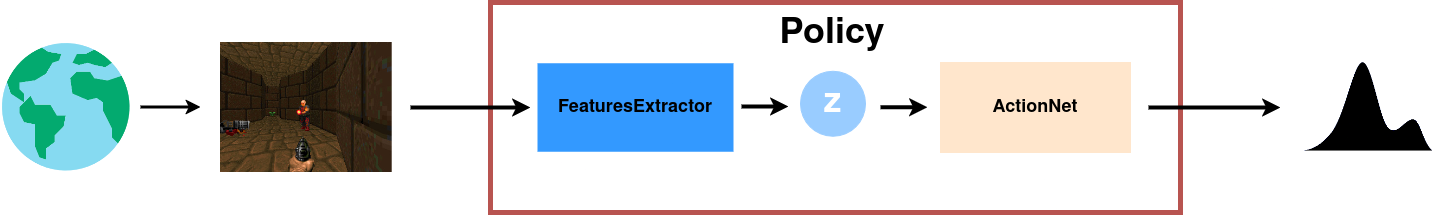

In [ ]:
class Encoder(nn.Module):
    def __init__(
            self,
            observation_space: gym.Space,
            features_dim: int = 512,
    ) -> None:
        super().__init__()
        self.features_dim = features_dim
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))


class Policy(nn.Module):
    def __init__(self, observation_space: gym.Space, action_space: gym.Space, lr: float,
                 optimizer_class: Type[torch.optim.Optimizer] = torch.optim.Adam,
                 optimizer_kwargs: Dict[str, Any] = {'eps': 1e-5},):
        super().__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        self.lr = lr
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = dict(optimizer_kwargs)
        self.features_extractor = self.make_features_extractor()
        self.action_net = nn.Linear(self.features_extractor.features_dim, self.action_space.n)
        self.value_net = nn.Linear(self.features_extractor.features_dim, 1)
        self.optimizer = self.optimizer_class(self.parameters(), lr=self.lr, **self.optimizer_kwargs)

    def make_features_extractor(self):
        return Encoder(self.observation_space)

    def extract_features(self, obs: torch.Tensor) -> torch.Tensor:
        obs = obs.float() / 255.
        features = self.features_extractor(obs)

        return features

    def forward(self, obs: torch.Tensor, deterministic: bool = False) -> Dict[str, torch.Tensor]:
        features = self.extract_features(obs)

        action_logits = self.action_net(features)
        distribution = Categorical(logits=action_logits)
        actions = distribution.mode() if deterministic else distribution.sample()
        actions = actions.reshape((-1, *self.action_space.shape))
        log_probs = distribution.log_prob(actions)
        values = self.value_net(features)

        return {'log_prob': log_probs, 'value': values, 'action': actions}

    def evaluate_actions(self, obs: torch.Tensor, actions_taken: torch.Tensor) -> Dict[str, torch.Tensor]:
        features = self.extract_features(obs)
        action_logits = self.action_net(features)
        distribution = Categorical(logits=action_logits)
        log_prob = distribution.log_prob(actions_taken)
        entropy = distribution.entropy()
        values = self.value_net(features)

        return {'log_prob': log_prob, 'value': values, 'entropy': entropy}

    def set_training_mode(self, mode: bool) -> None:
        self.train(mode)

#### NStepAdvantageBuffer
В буфере хранятся траектории, собранные агентом. Также в буфере производится вычисление частичных отдач и преимущества.

In [ ]:
class BufferSamples(NamedTuple):
    observations: torch.Tensor
    actions: torch.Tensor
    log_probs: torch.Tensor
    returns: torch.Tensor
    advantages: torch.Tensor


class NStepAdvantageBuffer:
    def __init__(self, gamma: float = 0.99, device: Union[torch.device, str] = "cpu"):
        self.device = torch.device(device)
        self.gamma = gamma
        self.generator_ready = False
        self.observations = None
        self.actions = None
        self.rewards = None
        self.episode_starts = None
        self.log_probs = None
        self.values = None
        self.returns = None
        self.advantages = None

    def size(self) -> int:
        return len(self.actions)

    def reset(self) -> None:
        self.generator_ready = False
        self.observations = []
        self.actions = []
        self.rewards = []
        self.episode_starts = []
        self.log_probs = []
        self.values = []
        self.returns = None
        self.advantages = None

    def add(
            self,
            obs: np.ndarray,
            action: int,
            reward: float,
            episode_start: bool,
            log_prob: float,
            value: float,
    ) -> None:
        self.observations.append(obs)
        self.actions.append(action)
        self.rewards.append(reward)
        self.episode_starts.append(episode_start)
        self.log_probs.append(log_prob)
        self.values.append(value)

    def compute_returns_and_advantage(self, last_value: float, last_terminated: bool) -> None:
        rewards = self.rewards
        episode_starts = self.episode_starts
        values = self.values
        assert len(episode_starts) == len(rewards)
        assert len(values) == len(rewards)

        episode_starts.append(last_terminated)
        values.append(last_value)
        returns = [None] * len(self.rewards)
        advantages = [None] * len(self.rewards)
        reward_to_go = values[-1]
        for step in reversed(range(len(self.rewards))):
            is_next_step_terminal = episode_starts[step + 1]
            reward_to_go = rewards[step] + self.gamma * reward_to_go * (1 - is_next_step_terminal)
            returns[step] = reward_to_go
            advantages[step] = reward_to_go - values[step]

        self.returns = returns
        self.advantages = advantages

    def to_torch(self, array: np.ndarray) -> torch.Tensor:
        return torch.tensor(array, device=self.device)

    def _get_samples(
            self,
            batch_inds: np.ndarray,
    ) -> BufferSamples:
        observations = self.to_torch(self.observations[batch_inds])
        actions = self.to_torch(self.actions[batch_inds])
        log_probs = self.to_torch(self.log_probs[batch_inds])
        returns = self.to_torch(self.returns[batch_inds])
        advantages = self.to_torch(self.advantages[batch_inds])

        return BufferSamples(observations=observations, actions=actions, log_probs=log_probs, returns=returns,
                             advantages=advantages)

    def get(self, batch_size: Optional[Union[int, float]] = None) -> Generator[BufferSamples, None, None]:
        buffer_size = self.size()
        indices = np.random.permutation(buffer_size)
        if not self.generator_ready:
            self.observations = np.asarray(self.observations)
            self.actions = np.asarray(self.actions)
            self.log_probs = np.asarray(self.log_probs, dtype=np.float32)
            self.returns = np.asarray(self.returns, dtype=np.float32)
            self.advantages = np.asarray(self.advantages, dtype=np.float32)
            self.generator_ready = True

        if batch_size is None or math.isinf(batch_size):
            batch_size = buffer_size

        start_idx = 0
        while start_idx < buffer_size:
            yield self._get_samples(indices[start_idx: start_idx + batch_size])
            start_idx += batch_size

#### Surrogate Policy Optimization (2 балла)

In [ ]:
class SPO:
    def __init__(
        self, env: gym.Env, learning_rate: float = 2.5e-4, gamma: float = 0.99,
        ent_coef: float = 0.01, max_grad_norm: float = 0.5, stats_window_size: int = 10,
        policy_class: Type[nn.Module] = Policy, policy_kwargs: Optional[Dict[str, Any]] = {},
        seed: Optional[int] = None, device: Union[torch.device, str] = "cuda",
        buffer_class: Type[NStepAdvantageBuffer] = NStepAdvantageBuffer, buffer_kwargs: Optional[Dict[str, Any]] = {},
        vf_coef: float = 0.5, n_steps: int = 128, batch_size: int = 32,
        n_epochs: int = 1, normalize_advantage: bool = False,
    ):
        self.device = device if isinstance(device, torch.device) else torch.device(device)
        print(f"Using {self.device} device")

        self.num_timesteps = 0
        self._num_timesteps_at_start = 0
        self._episode_num = 0
        self.seed = seed
        self.start_time = 0.0
        self.learning_rate = learning_rate
        self._last_obs = None
        self._last_episode_start = None
        self._stats_window_size = stats_window_size
        self.ep_info_buffer = deque(maxlen=self._stats_window_size)
        self._n_updates = 0

        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.env = env

        self.gamma = gamma
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef
        self.n_steps = n_steps
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.normalize_advantage = normalize_advantage
        self.max_grad_norm = max_grad_norm
        self.log_dict = {}

        self.set_random_seed(self.seed)
        self.buffer_class = buffer_class
        self.buffer_kwargs = buffer_kwargs
        self.buffer = self.buffer_class(
            device=self.device,
            gamma=self.gamma,
            **self.buffer_kwargs,
        )
        self.policy_class = policy_class
        self.policy_kwargs = policy_kwargs
        self.policy = self.policy_class(
            self.observation_space, self.action_space, self.learning_rate, **self.policy_kwargs
        )
        self.policy = self.policy.to(self.device)

    def _update_info_buffer(self, info: Dict[str, Any]) -> None:
        # Collect statistics
        assert self.ep_info_buffer is not None

        ep_info = info.get("episode")
        if ep_info is not None:
            self.ep_info_buffer.append(ep_info)

    def set_random_seed(self, seed: Optional[int] = None) -> None:
        if seed is None:
            return
        set_seed_everywhere(seed, using_cuda=self.device.type == torch.device("cuda").type)
        self.action_space.seed(seed)
        self.observation_space.seed(seed)

    def train(self) -> None:
        self.policy.set_training_mode(True)

        entropy_losses = []
        entropies = []
        pg_losses = []
        value_losses = []
        losses = []
        grad_norms = []
        log_ratios = {}
        log_fractions = {}

        for epoch in range(self.n_epochs):
            log_ratios[epoch] = []
            log_fractions[epoch] = {0.05: [], 0.10: [], 0.20: []}
            for rollout_data in self.buffer.get(self.batch_size):
                actions = rollout_data.actions.long()
                policy_output = self.policy.evaluate_actions(rollout_data.observations, actions)
                log_prob = policy_output['log_prob']
                entropy = policy_output['entropy']
                values = policy_output['value']
                advantages = rollout_data.advantages
                if self.normalize_advantage and len(advantages) > 1:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # Policy loss
                # old_log_prob = ...
                # ratio = ...
                # policy_loss = ...
                """<codehere>"""
                raise NotImplementedError
                """</codehere>"""

                # Logging policy loss
                pg_losses.append(policy_loss.item())

                # Логируем степень изменения стратегии
                log_ratios[epoch].append(ratio.mean().item())
                for log_range in log_fractions[epoch]:
                    fraction = torch.mean((torch.abs(ratio - 1) > log_range).float()).item()
                    log_fractions[epoch][log_range].append(fraction)

                # Entropy loss
                entropy = torch.mean(entropy)
                entropy_loss = -self.ent_coef * entropy
                entropies.append(entropy.item())
                entropy_losses.append(entropy_loss.item())

                # Value loss
                value_loss = self.vf_coef * F.mse_loss(values, rollout_data.returns.reshape_as(values))
                value_losses.append(value_loss.item())

                loss = policy_loss + entropy_loss + value_loss
                losses.append(loss.item())

                # Optimization step
                self.policy.optimizer.zero_grad()
                loss.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                grad_norms.append(grad_norm.item())
                self.policy.optimizer.step()

            self._n_updates += 1

        self.log_dict = dict([
            ("train/entropy_loss", np.mean(entropy_losses)), ("train/entropy", np.mean(entropies)),
            ("train/policy_gradient_loss", np.mean(pg_losses)), ("train/loss", np.mean(losses)),
            ("train/grad_norm", np.mean(grad_norms)), ("train/n_updates", self._n_updates),
            ("train/value_loss", np.mean(value_losses)),
        ])

        for epoch in log_ratios.keys():
            self.log_dict[f"train/ratio_epoch-{epoch}"] = np.mean(log_ratios[epoch])

        for epoch in log_fractions.keys():
            for ration_range in log_fractions[epoch]:
                self.log_dict[f"train/fraction-{ration_range}_epoch-{epoch}"] = np.mean(log_fractions[epoch][ration_range])

    def collect_rollouts(
            self,
            env,
            buffer: NStepAdvantageBuffer,
    ):
        self.policy.set_training_mode(False)
        assert self._last_obs is not None, "No previous observation was provided"
        self._last_obs = np.array(self._last_obs)

        step = 0
        buffer.reset()
        while step < self.batch_size:
            with torch.no_grad():
                obs_tensor = torch.as_tensor(self._last_obs, device=self.device)
                policy_output = self.policy(obs_tensor.unsqueeze(0))
                action = policy_output['action'].item()
                value = policy_output['value'].item()
                log_prob = policy_output['log_prob'].item()
            new_obs, reward, terminated, truncated, info = env.step(action)
            assert not truncated, 'We do not handle truncation by episode time_limit for simplicity'

            step += 1
            self.num_timesteps += 1
            self._episode_num += int(terminated)
            # Сохранить данные в буфер: наблюдение, действие, награда, флаг начала эпизода, полезность
            buffer.add(
                self._last_obs,
                action,
                reward,
                self._last_episode_start,
                log_prob,
                value,
            )

            self._update_info_buffer(info)
            # Обработка флага terminated: при завершении эпизода вызываем env.reset()
            self._last_episode_start = terminated
            if terminated:
                self._last_obs, _ = env.reset()
            else:
                self._last_obs = new_obs

            self._last_obs = np.asarray(self._last_obs)


        # Вычисление отдач в буфере: buffer.computer_returns(...)
        last_value = self.policy(torch.as_tensor(np.array(new_obs), device=self.device).unsqueeze(0))['value'].item()
        buffer.compute_returns_and_advantage(last_value=last_value, last_terminated=terminated)

    def learn(
            self,
            max_timesteps: int,
            expected_return: float,
            log_interval: int = 1000,
            save_checkpoint_path: str = None,
            save_checkpoint_interval: int = 5000,
    ) -> None:
        assert self.env is not None

        self.start_time = time.time_ns()
        self.num_timesteps = 0
        self._episode_num = 0
        self._num_timesteps_at_start = 0
        log_interval = log_interval or math.inf
        next_log_step = self.num_timesteps + log_interval

        if save_checkpoint_interval is None or save_checkpoint_path is None:
            save_checkpoint_interval = math.inf

        next_save_step = self.num_timesteps + save_checkpoint_interval

        if self._last_obs is None:
            self._last_obs, _ = self.env.reset(seed=self.seed)
            self._last_episode_start = True

        iteration = 0
        while True:
            if self.get_current_mean_return() >= expected_return:
                print('Решено!')
                break

            if self.num_timesteps >= max_timesteps:
                print(f'Задача не решена за {max_timesteps} шагов')
                break

            self.collect_rollouts(self.env, self.buffer,)
            iteration += 1

            if self.num_timesteps >= next_log_step:
                next_log_step += log_interval
                assert self.ep_info_buffer is not None
                self._dump_logs(iteration)

            if self.num_timesteps >= next_save_step:
                next_save_step += save_checkpoint_interval
                checkpoint = {'policy': self.policy.state_dict(), 'optimizer': self.policy.optimizer.state_dict(),
                              'num_timesteps': self.num_timesteps, 'episode_num': self._episode_num,
                              'ep_info_buffer': self.ep_info_buffer}
                os.makedirs(save_checkpoint_path, exist_ok=True)
                torch.save(checkpoint, os.path.join(save_checkpoint_path, 'checkpoint.pt'))

            self.train()

    def get_current_mean_return(self) -> float:
        if len(self.ep_info_buffer) == 0:
            return -math.inf

        return np.mean(np.concatenate([ep_info["r"] for ep_info in self.ep_info_buffer])).item()

    def _dump_logs(self, iteration: int) -> None:
        assert self.ep_info_buffer is not None

        time_elapsed = max((time.time_ns() - self.start_time) / 1e9, sys.float_info.epsilon)
        fps = int((self.num_timesteps - self._num_timesteps_at_start) / time_elapsed)
        self.log_dict["time/iterations"] = iteration
        if len(self.ep_info_buffer) > 0 and len(self.ep_info_buffer[0]) > 0:
            self.log_dict["rollout/ep_rew_mean"] = self.get_current_mean_return()
            self.log_dict["rollout/ep_len_mean"] = np.mean(
                np.concatenate([ep_info["l"] for ep_info in self.ep_info_buffer])).item()

        self.log_dict["time/fps"] = fps
        self.log_dict["time/time_elapsed"] = int(time_elapsed)
        self.log_dict["global_step"] = self.num_timesteps
        self.log_dict["num_episodes"] = self._episode_num
        print(json.dumps(self.log_dict, sort_keys=True, indent=4))

        if WANDB_IS_AVAILABLE and wandb.run is not None:
            wandb.log(self.log_dict)

In [ ]:
def run_algorithm(algorithm_class, algorithm_kwargs, use_wandb, wandb_kwargs, learn_kwargs):
    env = make_env()
    model = algorithm_class(env, **algorithm_kwargs)
    if use_wandb:
        config = {}
        config.update(algorithm_kwargs)
        config.update(learn_kwargs)
        config.update(wandb_kwargs.get('config', {}))
        wandb_kwargs['config'] = config
        if wandb.run is not None:
            wandb.finish()

        wandb.init(**wandb_kwargs)

    model.learn(**learn_kwargs)
    if use_wandb:
        wandb.finish()

In [ ]:
run_algorithm(
    algorithm_class=SPO,
    algorithm_kwargs=dict(seed=0, normalize_advantage=False, n_epochs=1,),
    use_wandb=False,
    wandb_kwargs=dict(project='seminar_ppo', monitor_gym=True, name='SPO'),
    learn_kwargs=dict(max_timesteps=50000, log_interval=1000, expected_return=2000,
                      save_checkpoint_path='/content/drive/My Drive/seminar_ppo/1_spo',
                      save_checkpoint_interval=1000)
)

# 2 Proximal Policy Optimization
Как гарантировать, что обновление стратегии не приведёт к большим изменениям?

В практической реализации существует два варианта реализации алгоритма PPO:
* Penalty: выполняет обновление, ограниченное KL-дивергенцией, как TRPO, но штрафует KL-дивергенцией в целевой функции вместо того, чтобы делать его жестким ограничением, и автоматически регулирует коэффициент штрафа в процессе обучения, чтобы он масштабировался соответствующим образом.
* Clip: более простой вариант, не содержит в целевой функции члена KL-дивергенции и вообще не имеет ограничения, но полагается на специализированный клиппинг. Параметр $\epsilon$ называется `clip_range`.

<img src="https://spinningup.openai.com/en/latest/_images/math/e62a8971472597f4b014c2da064f636ffe365ba3.svg">
<br><br>
<img src="https://spinningup.openai.com/en/latest/_images/math/39f524858866b80e627840ba77a54360e3bac55e.svg">

<br><br>

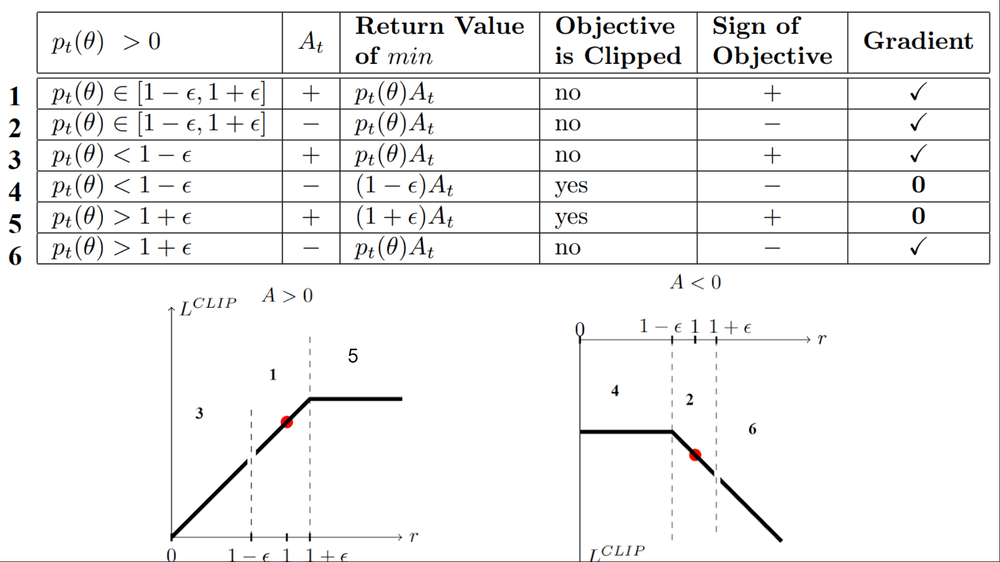

#### Как отношение вероятностей обновлённой и старой стратегии коррелирует со стабильностью обучения?
Визаулизация степени изменения стратегии во время обучения:
- **A2C**: https://wandb.ai/ula_elfray/a2c_PongNoFrameskip-v4/reports/A2C-Atari-Pong---VmlldzoxMTczNzEwNw

(2 балла)

In [ ]:
class PPO(SPO):
    def __init__(
        self, env: gym.Env, learning_rate: float = 2.5e-4, gamma: float = 0.99,
        ent_coef: float = 0.01, max_grad_norm: float = 0.5, stats_window_size: int = 10,
        policy_class: Type[nn.Module] = Policy, policy_kwargs: Optional[Dict[str, Any]] = {},
        seed: Optional[int] = None, device: Union[torch.device, str] = "cuda",
        buffer_class: Type[NStepAdvantageBuffer] = NStepAdvantageBuffer, buffer_kwargs: Optional[Dict[str, Any]] = {},
        vf_coef: float = 0.5, n_steps: int = 128, batch_size: int = 32,
        n_epochs: int = 1, normalize_advantage: bool = False,
        clip_range: float = math.inf,
    ):
        super().__init__(
            env, learning_rate, gamma,
            ent_coef, max_grad_norm, stats_window_size,
            policy_class, policy_kwargs, seed,
            device, buffer_class, buffer_kwargs, vf_coef, n_steps,
            batch_size, n_epochs, normalize_advantage,
        )
        self.clip_range = clip_range

    def train(self) -> None:
        self.policy.set_training_mode(True)

        entropy_losses = []
        entropies = []
        pg_losses = []
        value_losses = []
        losses = []
        grad_norms = []
        clip_fractions = []
        log_ratios = {}
        log_fractions = {}

        for epoch in range(self.n_epochs):
            log_ratios[epoch] = []
            log_fractions[epoch] = {0.05: [], 0.10: [], 0.20: []}
            for rollout_data in self.buffer.get(self.batch_size):
                actions = rollout_data.actions.long()
                policy_output = self.policy.evaluate_actions(rollout_data.observations, actions)
                log_prob = policy_output['log_prob']
                entropy = policy_output['entropy']
                values = policy_output['value']
                advantages = rollout_data.advantages
                if self.normalize_advantage and len(advantages) > 1:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # Policy loss
                # old_log_prob = ...
                # ratio = ...
                # policy_loss_1 = ... (аналогично policy_loss в классе PPO)
                # policy_loss_2 = ... (клипирование ratio с помощью torch.clamp(...), диапазон клипирования: self.clip_range)
                """<codehere>"""
                raise NotImplementedError
                """</codehere>"""
                policy_loss = -torch.min(policy_loss_1, policy_loss_2).mean()

                # Logging policy loss
                pg_losses.append(policy_loss.item())
                # Логируем долю состояний, в которых сработало клиппирование
                clip_fraction = torch.mean((torch.abs(ratio - 1) > self.clip_range).float()).item()
                clip_fractions.append(clip_fraction)

                # Логируем степень изменения стратегии
                log_ratios[epoch].append(ratio.mean().item())
                for log_range in log_fractions[epoch]:
                    fraction = torch.mean((torch.abs(ratio - 1) > log_range).float()).item()
                    log_fractions[epoch][log_range].append(fraction)

                # Entropy loss
                entropy = torch.mean(entropy)
                entropy_loss = -self.ent_coef * entropy
                entropies.append(entropy.item())
                entropy_losses.append(entropy_loss.item())

                # Value loss
                value_loss = self.vf_coef * F.mse_loss(values, rollout_data.returns.reshape_as(values))
                value_losses.append(value_loss.item())

                loss = policy_loss + entropy_loss + value_loss
                losses.append(loss.item())

                # Optimization step
                self.policy.optimizer.zero_grad()
                loss.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                grad_norms.append(grad_norm.item())
                self.policy.optimizer.step()

            self._n_updates += 1

        self.log_dict = dict([
            ("train/entropy_loss", np.mean(entropy_losses)), ("train/entropy", np.mean(entropies)),
            ("train/policy_gradient_loss", np.mean(pg_losses)), ("train/loss", np.mean(losses)),
            ("train/grad_norm", np.mean(grad_norms)), ("train/n_updates", self._n_updates),
            ("train/value_loss", np.mean(value_losses)), ("train/clip_fraction", np.mean(clip_fractions)),
            ("train/clip_range", self.clip_range),
        ])

        for epoch in log_ratios.keys():
            self.log_dict[f"train/ratio_epoch-{epoch}"] = np.mean(log_ratios[epoch])

        for epoch in log_fractions.keys():
            for ration_range in log_fractions[epoch]:
                self.log_dict[f"train/fraction-{ration_range}_epoch-{epoch}"] = np.mean(log_fractions[epoch][ration_range])

In [ ]:
run_algorithm(
    algorithm_class=PPO,
    algorithm_kwargs=dict(seed=0, normalize_advantage=False, n_epochs=1, clip_range=0.1),
    use_wandb=False,
    wandb_kwargs=dict(project='seminar_ppo', monitor_gym=True, name='PPO'),
    learn_kwargs=dict(max_timesteps=50000, log_interval=1000, expected_return=2000,
                      save_checkpoint_path='/content/drive/My Drive/seminar_ppo/2_ppo',
                      save_checkpoint_interval=1000)
)

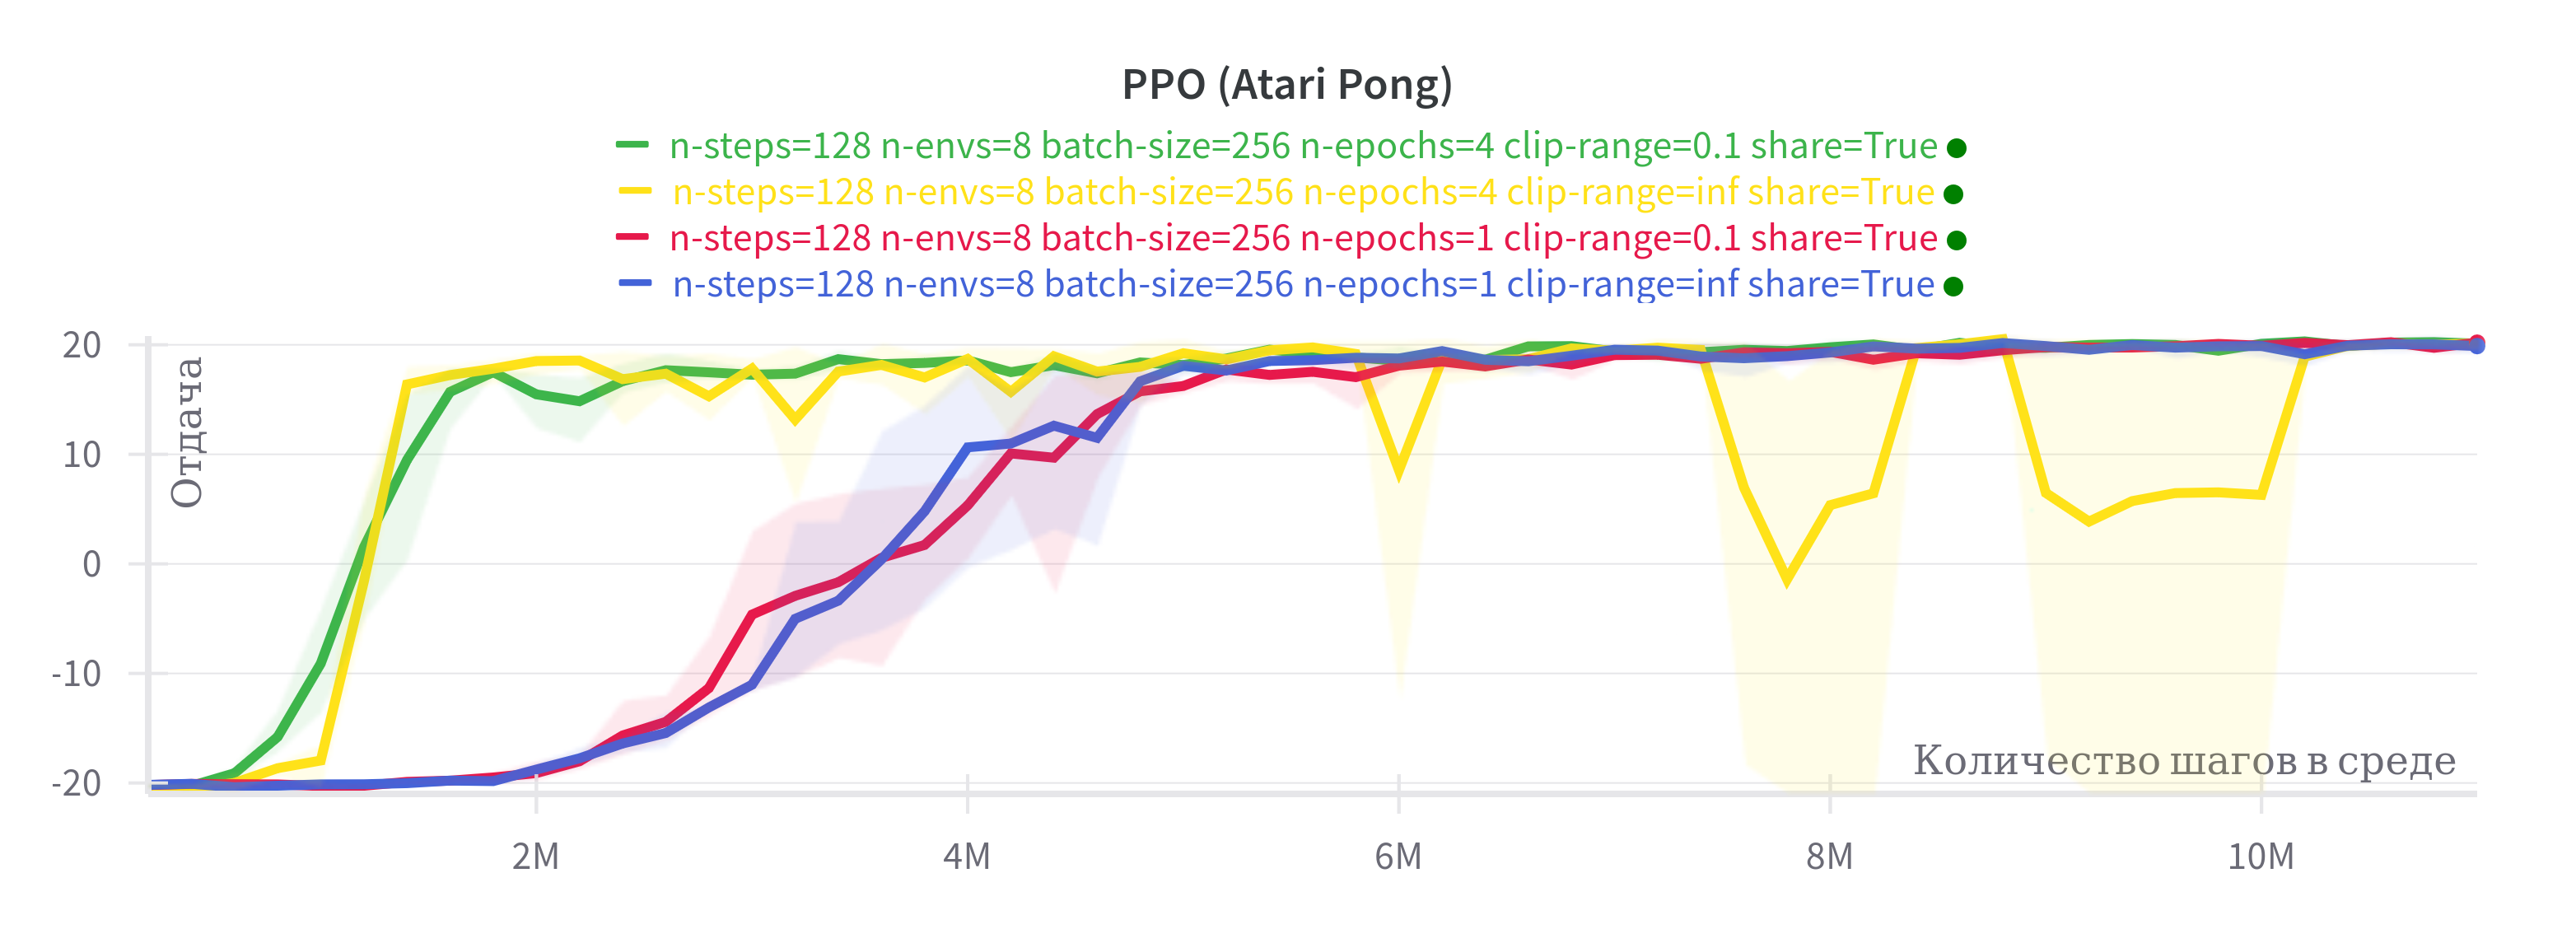

Визаулизация степени изменения стратегии во время обучения:
- **PPO**: https://wandb.ai/ula_elfray/ppo_PongNoFrameskip-v4/reports/PPO-Atari-Pong---VmlldzoxMTczNzI4Nw

### Влияние параметров и реализации на производительность PPO:
Спойлер: клиппинг - не самое главное в PPO, как это могло показаться на первый взгляд. Алгоритм PPO работает во многом и за счет небольших дополнительных улучшений. Подробнее:
- https://arxiv.org/abs/2005.12729
- https://arxiv.org/abs/2006.05990
- https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

# 3 Раздельные features extractor для актора и критика

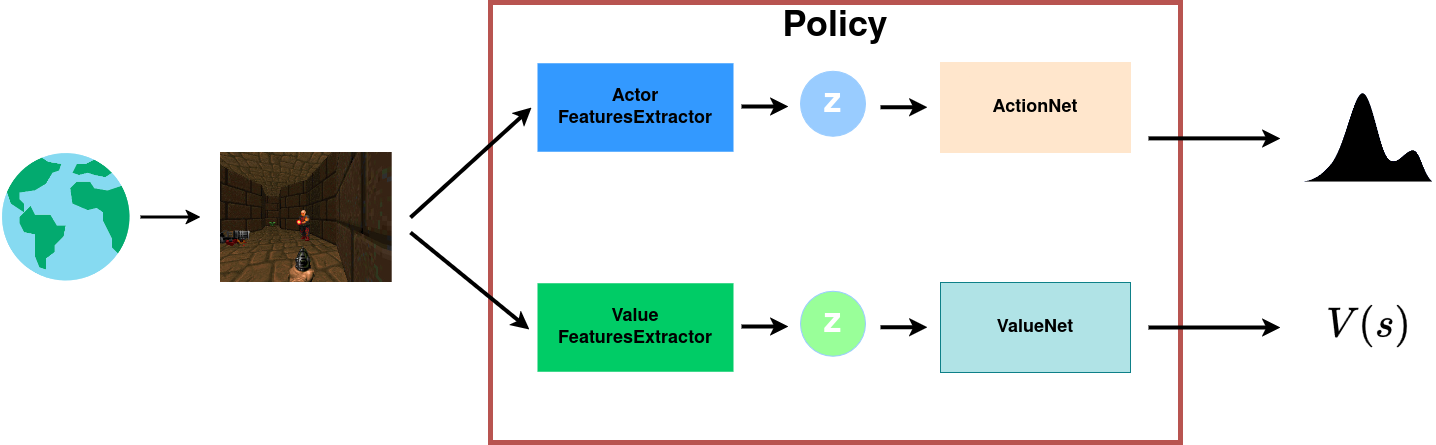

(4 балла)

In [ ]:
class PolicySeparateFeaturesExtractors(nn.Module):
    def __init__(self, observation_space: gym.Space, action_space: gym.Space, lr: float,
                 optimizer_class: Type[torch.optim.Optimizer] = torch.optim.Adam,
                 optimizer_kwargs: Dict[str, Any] = {'eps': 1e-5}):
        super().__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        self.lr = lr
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = dict(optimizer_kwargs)
        # Отдельные features_extractor для актора и критика
        # self.actor_features_extractor = ...
        # self.value_features_extractor = ...
        """<codehere>"""
        raise NotImplementedError
        """</codehere>"""
        self.action_net = nn.Linear(self.actor_features_extractor.features_dim, self.action_space.n)
        self.value_net = nn.Linear(self.value_features_extractor.features_dim, 1)
        self.optimizer = self.optimizer_class(self.parameters(), lr=self.lr, **self.optimizer_kwargs)

    def make_features_extractor(self):
        return Encoder(self.observation_space)

    def extract_features(self, obs: torch.Tensor) -> torch.Tensor:
        # actor_features = ...
        # value_features = ...
        """<codehere>"""
        raise NotImplementedError
        """</codehere>"""

        return actor_features, value_features

    def forward(self, obs: torch.Tensor, deterministic: bool = False) -> Dict[str, torch.Tensor]:
        # actor_features = ...
        # value_features = ...
        """<codehere>"""
        raise NotImplementedError
        """</codehere>"""
        action_logits = self.action_net(actor_features)
        distribution = Categorical(logits=action_logits)
        actions = distribution.mode() if deterministic else distribution.sample()
        actions = actions.reshape((-1, *self.action_space.shape))
        log_probs = distribution.log_prob(actions)
        values = self.value_net(value_features)

        return {'log_prob': log_probs, 'value': values, 'action': actions}

    def evaluate_actions(self, obs: torch.Tensor, actions_taken: torch.Tensor) -> Dict[str, torch.Tensor]:
        # actor_features = ...
        # value_features = ...
        """<codehere>"""
        raise NotImplementedError
        """</codehere>"""
        action_logits = self.action_net(actor_features)
        distribution = Categorical(logits=action_logits)
        log_prob = distribution.log_prob(actions_taken)
        entropy = distribution.entropy()
        values = self.value_net(value_features)

        return {'log_prob': log_prob, 'value': values, 'entropy': entropy}

    def set_training_mode(self, mode: bool) -> None:
        self.train(mode)

In [ ]:
run_algorithm(
    algorithm_class=PPO,
    algorithm_kwargs=dict(seed=0, normalize_advantage=False, n_epochs=1, clip_range=0.1, policy_class=PolicySeparateFeaturesExtractors),
    use_wandb=False,
    wandb_kwargs=dict(project='seminar_ppo', monitor_gym=True, name='PPO-non-shared'),
    learn_kwargs=dict(max_timesteps=100000, log_interval=1000, expected_return=2000,
                      save_checkpoint_path='/content/drive/My Drive/seminar_ppo/3_ppo-non-shared',
                      save_checkpoint_interval=1000)
)

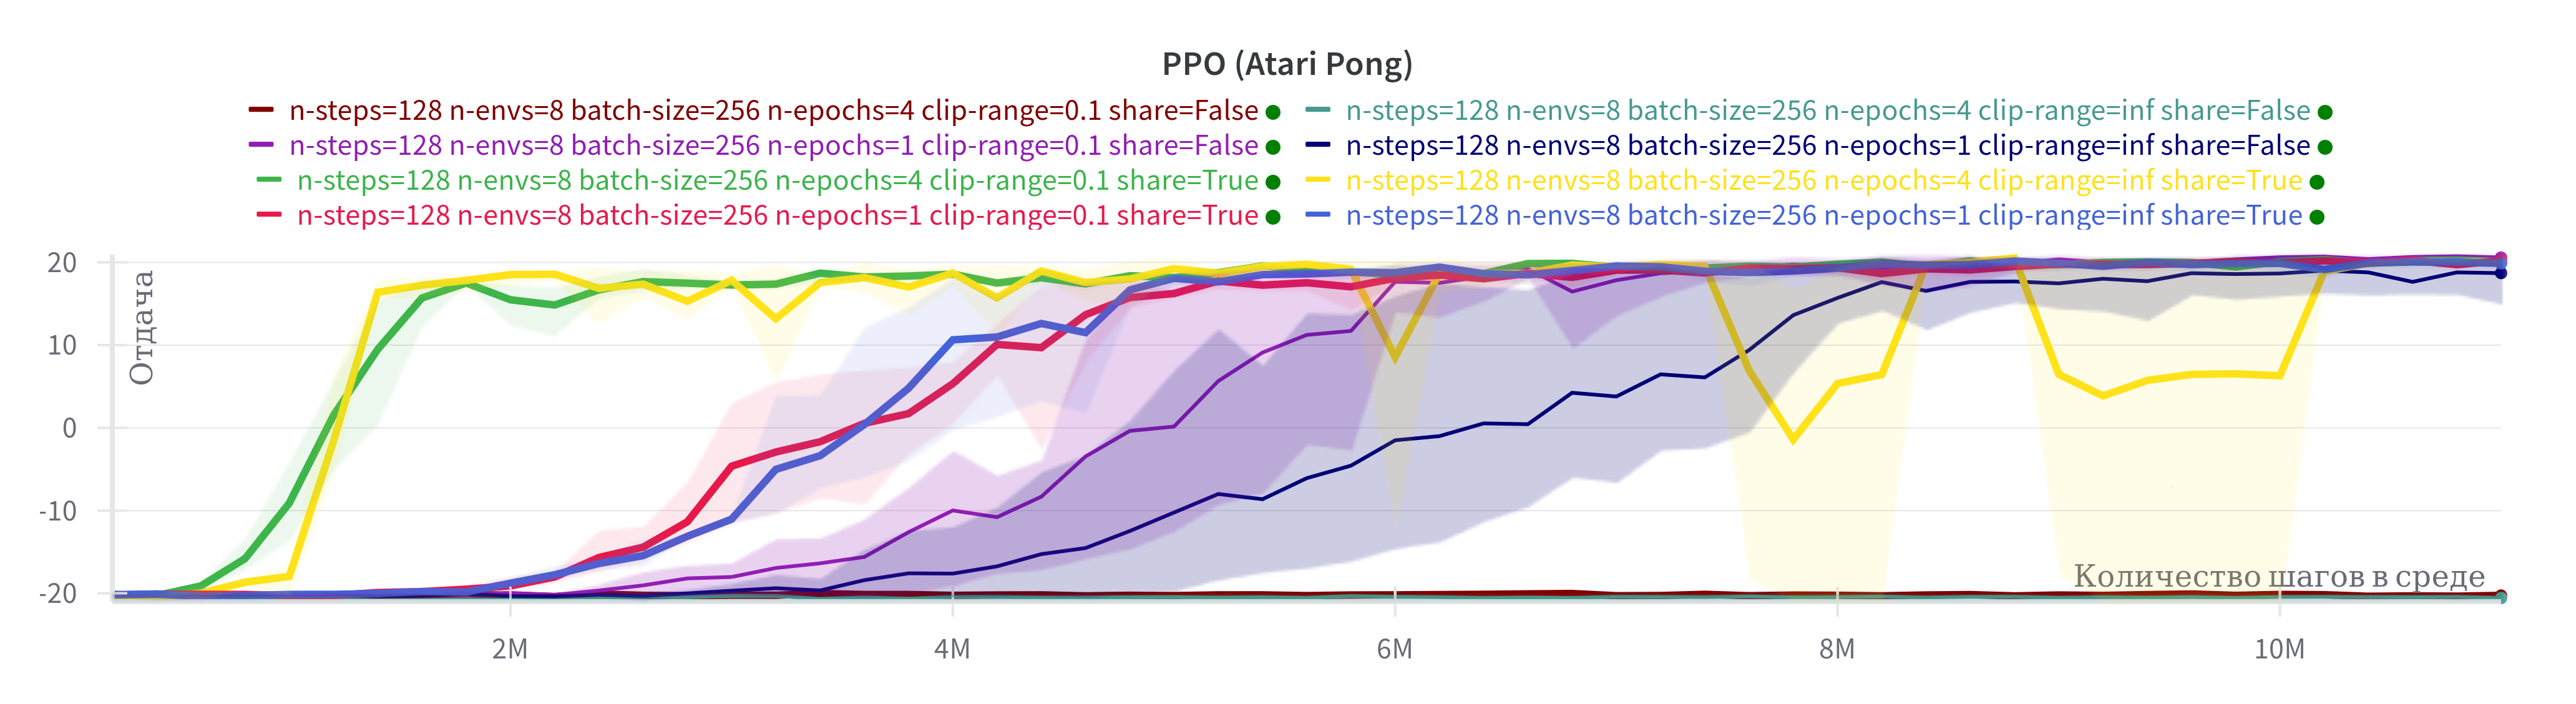

# 4 Обобщённая оценка преимущества (general advantage estimation)
Обобщенная оценка преимущества (GAE) — это метод оценки преимущества, объединяющий ошибку временных различий (TD) и оценку по методу Монте-Карло, что позволяет сбалансировать смещение и дисперсию оценки.

N-шаговая отдача:
$$G_t ^ {(N)} = \sum_{k = 0} ^ {N - 1} \gamma ^ k r_{t + k} + \gamma ^ N V(s_{t + N}) $$
$$ G_t ^ {(1)} = r_t + \gamma V(s_{t + 1}) \ \ \ \ \ \ \ \ G_t ^ {(\infty)} = G_t ^ {(T)} = \sum_{k = 0} ^ {T - 1} \gamma ^ k r_{t + k} $$
$\lambda$-отдача:
$$G_t (\lambda) = (1-\lambda) \sum_{n = 0} ^ {\infty} \lambda ^ {n - 1} G_t ^ {(n)}, \ \ \ \ \ \ \ 0 \le \lambda \le 1 $$
Для конечного эпизода $G_t ^ {(n)} = G_t ^ {T - t}$ при $n \ge T - t$:
$$G_t (\lambda) = (1 - \lambda) \sum_{n =1} ^ {T - t -1} \lambda ^ {n -1} G_t ^n + \lambda ^ {T - t - 1} G_t ^ {T - t}$$
$$G_t(0) = G_t ^ {(1)} \ \ \ \ \ \ \ \ \ \ \ G_t (1) = G_t ^ {(\infty)} = G_t ^ {(T)} $$

**Обобщённая оценка преимущества (general advantage estimation)**:
$$ A_t ^ {GAE} = G_t(\lambda) - V(s_t) $$
Вычисление через TD-ошибку $\delta_t$: $$\delta_t = r_t + \gamma V(s_{t + 1}) - V(s_t)$$
$$A_t ^ {GAE} = \delta_t + (\gamma \lambda) \delta_{t + 1} + (\gamma \lambda) ^ 2 \delta_{t + 2} + \dots $$

Рекуррентный вариант, удобный для вычисления $A_t ^ {GAE}$ по траектории за один проход:
$$A_t ^ {GAE} = \delta_t + (\gamma \lambda) A_{t+1} ^ {GAE}$$

(2 балла)

In [ ]:
class NStepGAEBuffer(NStepAdvantageBuffer):
    def __init__(self, gamma: float = 0.99, gae_lambda: float = 1.0, device: Union[torch.device, str] = "cpu"):
        super().__init__(gamma, device)
        self.gae_lambda = gae_lambda

    def compute_returns_and_advantage(self, last_value: float, last_terminated: bool) -> None:
        rewards = self.rewards
        episode_starts = self.episode_starts
        values = self.values
        assert len(episode_starts) == len(rewards)
        assert len(values) == len(rewards)

        episode_starts.append(last_terminated)
        values.append(last_value)
        returns = [None] * len(self.rewards)
        advantages = [None] * len(self.rewards)
        # Реализовать вычисление GAE
        """<codehere>"""
        raise NotImplementedError
        """</codehere>"""

        self.returns = returns
        self.advantages = advantages

In [ ]:
run_algorithm(
    algorithm_class=PPO,
    algorithm_kwargs=dict(seed=0, normalize_advantage=False, n_epochs=1, clip_range=0.1, policy_class=PolicySeparateFeaturesExtractors,
                         buffer_class=NStepGAEBuffer, buffer_kwargs=dict(gae_lambda=0.95)),
    use_wandb=True,
    wandb_kwargs=dict(project='seminar_ppo', monitor_gym=True, name='PPO-GAE'),
    learn_kwargs=dict(max_timesteps=50000, log_interval=1000, expected_return=2000,
                      save_checkpoint_path='/content/drive/My Drive/seminar_ppo/4_ppo-gae',
                      save_checkpoint_interval=1000)
)

- Метод `learn`: реализует основной цикл RL-обучения: чередование фазы сбора данных (траекторий) агентом в среде - `collect_rollouts` и фазы обучения агента - `train`.
- Метод `collect_rollouts`: агент выполняет действия в среде согласно текущей стратегии, собирая триплеты **<observation, action, reward>** в буфер
- Метод `train`: обучение на собранных данных. Функция потерь состоит из двух слагаемых: градиент стратегии и энтропийная регуляризация. Энтропийная регуляризация делает стратегию более стохастичной, т.е. более устойчивой к шуму, помогает исследовать среду, предотвращает сходимость к субоптимальному решению (особенно в средах с дискретными действиями)

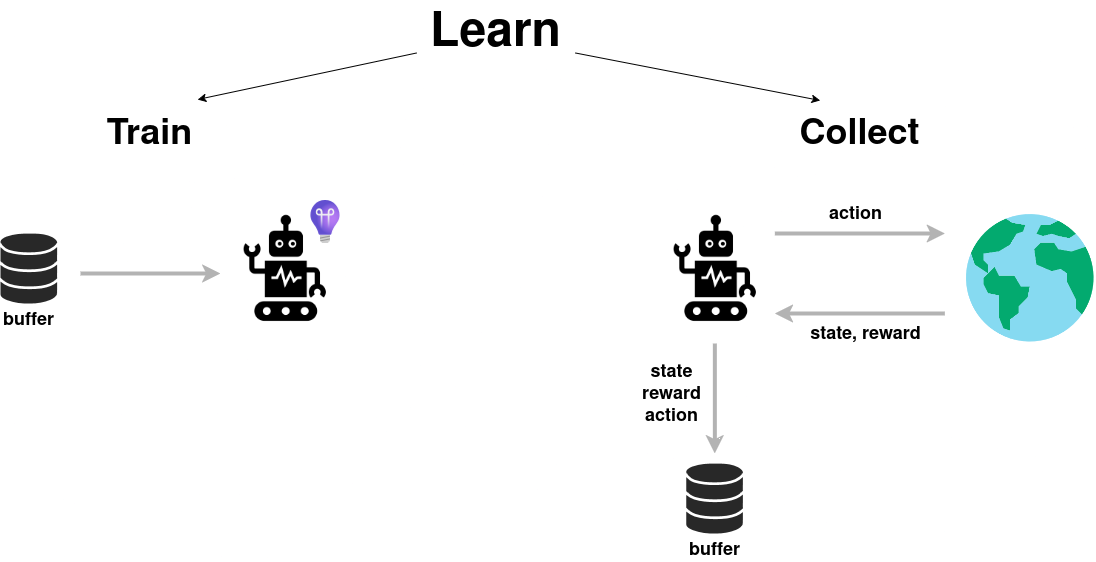